In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [51]:
df = pd.read_csv('data/kc_house_data.csv')

# Header cleaning. More precautionary than anything else
df.columns = [x.strip().lower().replace(' ','').replace('-','') for x in df.columns]

df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062


In [52]:
#First pass at cleaning
df['waterfront'].fillna('Unknown',inplace= True)
df['yr_renovated'].fillna(0,inplace= True)

df.dropna(subset=['view'],inplace=True)


In [53]:
# Removing outliers
df = df[df['bedrooms'] <=15] #Only 1 record remove. 33 Bed, 1.75 Bath?

In [54]:
# Change view rating to a numeric value. Probably don't need it
df['view'] = df['view'].map({'EXCELLENT':5,
                             'GOOD':4,
                             'FAIR':3,
                             'AVERAGE':2,
                             'NONE':1})

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21533 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21533 non-null  int64  
 1   date           21533 non-null  object 
 2   price          21533 non-null  float64
 3   bedrooms       21533 non-null  int64  
 4   bathrooms      21533 non-null  float64
 5   sqft_living    21533 non-null  int64  
 6   sqft_lot       21533 non-null  int64  
 7   floors         21533 non-null  float64
 8   waterfront     21533 non-null  object 
 9   view           21533 non-null  int64  
 10  condition      21533 non-null  object 
 11  grade          21533 non-null  object 
 12  sqft_above     21533 non-null  int64  
 13  sqft_basement  21533 non-null  object 
 14  yr_built       21533 non-null  int64  
 15  yr_renovated   21533 non-null  float64
 16  zipcode        21533 non-null  int64  
 17  lat            21533 non-null  float64
 18  long  

In [56]:
# The grading system
df['grade'].unique()

array(['7 Average', '6 Low Average', '8 Good', '11 Excellent', '9 Better',
       '5 Fair', '10 Very Good', '12 Luxury', '4 Low', '3 Poor',
       '13 Mansion'], dtype=object)

In [57]:
#Number of houses renovated in this dataset
df[df['yr_renovated']>0].shape[0]

743

In [43]:
df[df['bedrooms']>15]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [66]:
df['zipcode'].describe()

count    21533.000000
mean     98077.938188
std         53.507609
min      98001.000000
25%      98033.000000
50%      98065.000000
75%      98118.000000
max      98199.000000
Name: zipcode, dtype: float64

In [41]:
df_pairplotting1 = df.filter(['bedrooms','bathrooms','floors','view','price'])
df_pairplotting2 = df.filter(['bedrooms','sqft_living', 'sqft_lot','sqft_above','sqft_living15', 'sqft_lot15','price'])

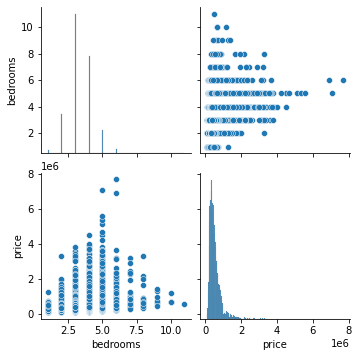

In [49]:
sns.pairplot(df.filter(['bedrooms','price']))

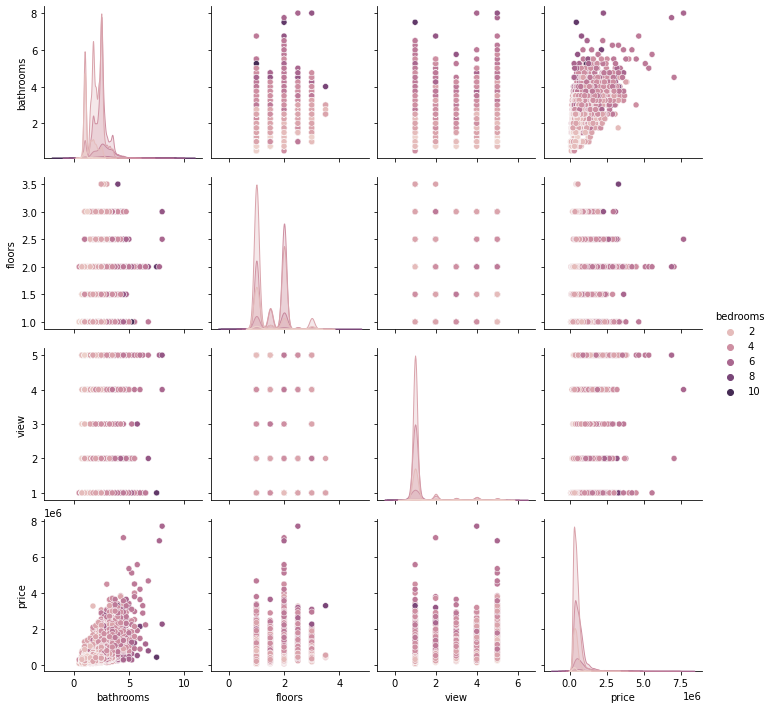

In [47]:
sns.pairplot(df_pairplotting1,hue = 'bedrooms')

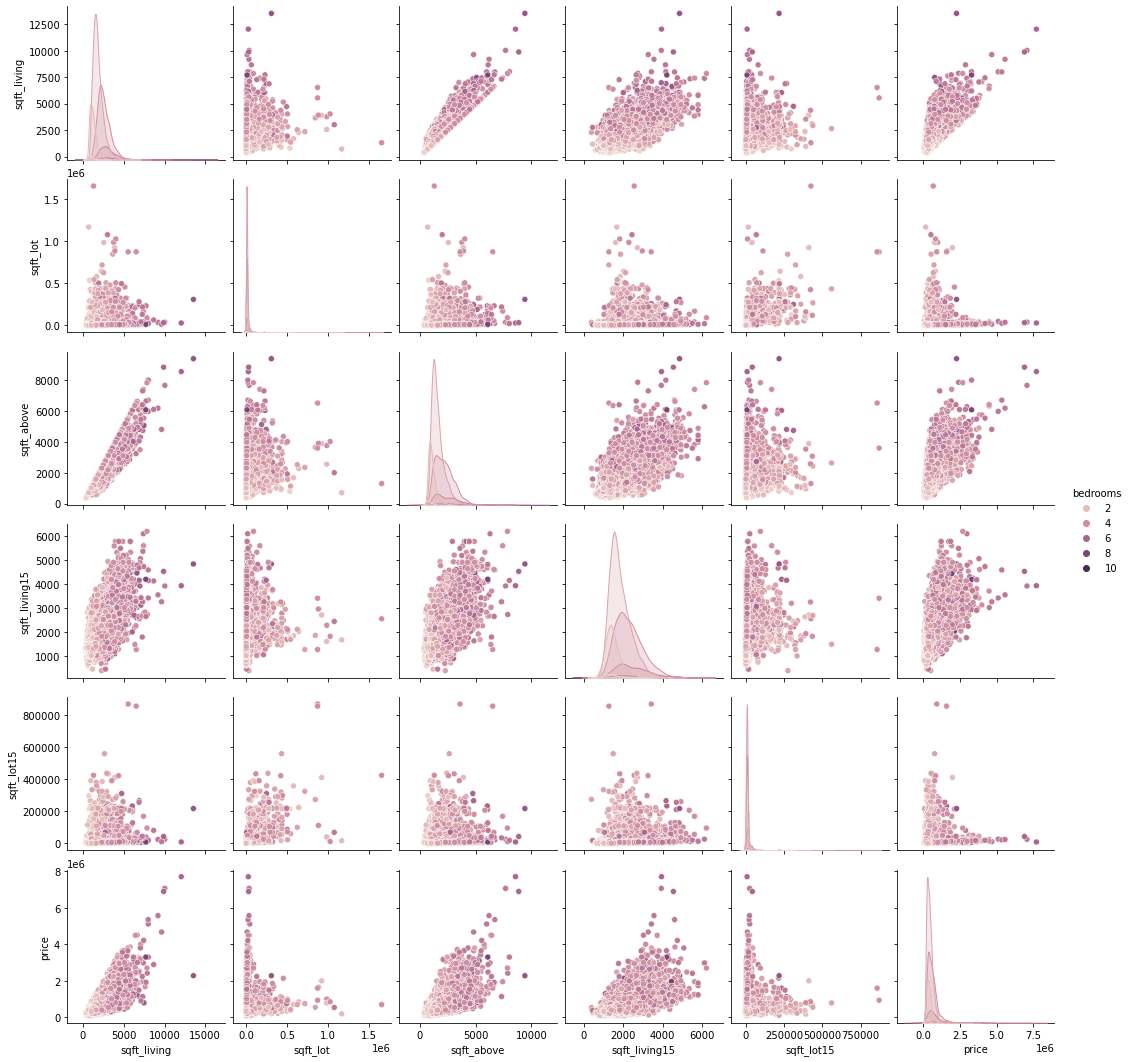

In [48]:
sns.pairplot(df_pairplotting2,hue = 'bedrooms')